C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

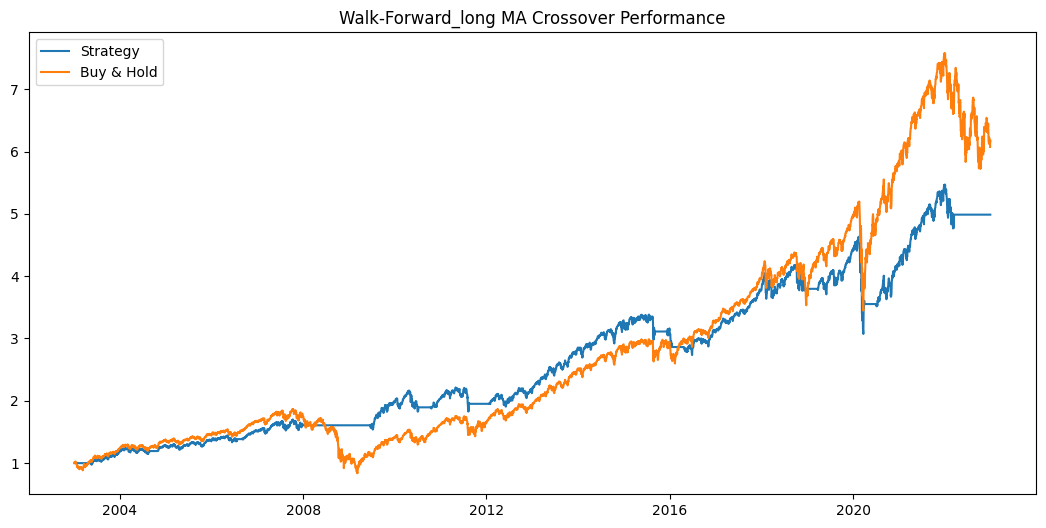

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

asset_list = [
    "SPY", "QQQ", "DIA",
    "EWJ", "EEM", "VGK",
    "TLT", "IEF", "BND",
    "GLD", "SLV", "USO",
    "EURUSD=X", "JPY=X", "AUDUSD=X",
    "BTC-USD", "ETH-USD"
]

# ============================
# Download price data
# ============================
def get_data(ticker):
    df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
    df = df[['Close']].dropna()
    return df


# ===============================================
# Apply MA crossover strategy inside one window
# ===============================================
def apply_strategy(df, fast=50, slow=200):
    df = df.copy()
    df['fast'] = df['Close'].rolling(fast).mean()
    df['slow'] = df['Close'].rolling(slow).mean()
    
    df['signal'] = 0
    df.loc[df['fast'] > df['slow'], 'signal'] = 1   # long
    df['signal'] = df['signal'].shift(1)            # trade next day
    df['signal'].fillna(0, inplace=True)

    # daily returns
    df['ret'] = df['Close'].pct_change().fillna(0)

    # strategy returns
    df['strategy_ret'] = df['signal'] * df['ret']

    return df[['signal', 'strategy_ret', 'ret']]

# ===============================================
# Walk-forward function
# ===============================================
def walk_forward(df, train_years=3, test_years=1, fast=50, slow=200):

    df = df.copy()
    results = []

    start = df.index.min()

    while True:
        train_start = start
        train_end = train_start + pd.DateOffset(years=train_years)
        test_end = train_end + pd.DateOffset(years=test_years)

        # break if test window exceeds data
        if test_end > df.index.max():
            break

        # slice windows
        train = df[(df.index >= train_start) & (df.index < train_end)]
        test = df[(df.index >= train_end) & (df.index < test_end)]

        # if too small skip
        if len(train) < slow + 5:
            start = start + pd.DateOffset(years=test_years)
            continue

        # train + test combined for MA calculation
        combined = pd.concat([train, test])

        # apply strategy
        window_results = apply_strategy(combined, fast, slow)

        # keep only test window results
        window_results = window_results.loc[test.index]

        results.append(window_results)

        # move forward
        start = start + pd.DateOffset(years=test_years)

    final = pd.concat(results)
    return final


# ===============================================
# Run it
# ===============================================
ticker = "SPY"
df = get_data(ticker)

results = walk_forward(df, train_years=3, test_years=1, fast=50, slow=200)

# cumulative returns
strategy_curve = (1 + results['strategy_ret']).cumprod()
buyhold_curve = (1 + results['ret']).cumprod()

# ===============================================
# Plot results
# ===============================================
plt.figure(figsize=(13,6))
plt.plot(strategy_curve, label="Strategy")
plt.plot(buyhold_curve, label="Buy & Hold")
plt.title("Walk-Forward_long MA Crossover Performance")
plt.legend()
plt.show()

In [78]:
def run_strategy_on_asset(ticker):
    df = get_data(ticker)
    results = walk_forward(df, fast=50, slow=200)
    return results.dropna()

In [ ]:
from fredapi import Fred

fred_key ='(your fred api key)'

fred = Fred(api_key=fred_key)


In [80]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

SPY
CAGR: 0.0837
Max Drawdown: -0.3372
Sharpe Ratio: -38.6443
Sortino Ratio: -42.1691
Profit Factor: 1.1563
30 days Rolling Sharpe: -inf
QQQ
CAGR: 0.1093
Max Drawdown: -0.2856
Sharpe Ratio: -30.0074
Sortino Ratio: -33.8168
Profit Factor: 1.1516
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

DIA
CAGR: 0.0674
Max Drawdown: -0.3933
Sharpe Ratio: -39.7552
Sortino Ratio: -43.0877
Profit Factor: 1.1326
30 days Rolling Sharpe: -inf
EWJ
CAGR: 0.0255
Max Drawdown: -0.3141
Sharpe Ratio: -37.8870
Sortino Ratio: -42.2209
Profit Factor: 1.0602
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

EEM
CAGR: 0.0001
Max Drawdown: -0.5080
Sharpe Ratio: -28.6901
Sortino Ratio: -33.0385
Profit Factor: 1.0214
30 days Rolling Sharpe: -33.8553
VGK
CAGR: 0.0154
Max Drawdown: -0.4104
Sharpe Ratio: -33.2844
Sortino Ratio: -37.0383
Profit Factor: 1.0446
30 days Rolling Sharpe: -37.7472



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

TLT
CAGR: 0.0254
Max Drawdown: -0.2706
Sharpe Ratio: -43.9166
Sortino Ratio: -49.2943
Profit Factor: 1.0628
30 days Rolling Sharpe: -39.8600
IEF
CAGR: 0.0257
Max Drawdown: -0.1044
Sharpe Ratio: -93.0922
Sortino Ratio: -95.2179
Profit Factor: 1.1068
30 days Rolling Sharpe: -67.3030



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

BND
CAGR: 0.0202
Max Drawdown: -0.0899
Sharpe Ratio: -139.0171
Sortino Ratio: -148.5388
Profit Factor: 1.1445
30 days Rolling Sharpe: -80.5342
GLD
CAGR: 0.0324
Max Drawdown: -0.3514
Sharpe Ratio: -39.4691
Sortino Ratio: -43.4898
Profit Factor: 1.0703
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

SLV
CAGR: 0.0498
Max Drawdown: -0.5937
Sharpe Ratio: -23.1441
Sortino Ratio: -28.6181
Profit Factor: 1.0942
30 days Rolling Sharpe: -14.5717
USO
CAGR: -0.0292
Max Drawdown: -0.7170
Sharpe Ratio: -24.5923
Sortino Ratio: -29.6449
Profit Factor: 0.9920
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

EURUSD=X
CAGR: 0.0018
Max Drawdown: -0.2180
Sharpe Ratio: -74.0437
Sortino Ratio: -80.6269
Profit Factor: 1.0165
30 days Rolling Sharpe: -inf
JPY=X
CAGR: 0.0056
Max Drawdown: -0.2902
Sharpe Ratio: -70.2063
Sortino Ratio: -74.5577
Profit Factor: 1.0296
30 days Rolling Sharpe: -36.6915



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

AUDUSD=X
CAGR: -0.0115
Max Drawdown: -0.3810
Sharpe Ratio: -71.2206
Sortino Ratio: -72.9641
Profit Factor: 0.9715
30 days Rolling Sharpe: -49.5336
BTC-USD
CAGR: 0.4342
Max Drawdown: -0.6915
Sharpe Ratio: -9.8337
Sortino Ratio: -14.0338
Profit Factor: 1.2187
30 days Rolling Sharpe: -20.6588
ETH-USD
CAGR: 0.7253
Max Drawdown: -0.5712
Sharpe Ratio: -8.2326
Sortino Ratio: -11.8585
Profit Factor: 1.2497
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)


In [ ]:
RISK_FREE_RATE = fred.get_series(series_id='TB3MS', observation_start = '2000-01-01', observation_end='2024-01-01').iloc[-1]

def compute_performance_metrics(df, risk_free_rate=RISK_FREE_RATE):
    df = df.copy()
    
    # Make sure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    
    init_equity = 10000
    
    # Correct equity curve calculation
    df['equity'] = init_equity * (1 + df['strategy_ret']).cumprod()
    
    # 1. CAGR - Use actual date range from the results
    total_years = (df.index[-1] - df.index[0]).days / 365.25
    final_equity = df['equity'].iloc[-1]
    cagr = (final_equity / init_equity) ** (1 / total_years) - 1
    
    # 2. Max Drawdown
    roll_max = df['equity'].cummax()
    drawdown = (df['equity'] - roll_max) / roll_max
    max_drawdown = drawdown.min()
    
    # 3. Sharpe Ratio (annualized)
    daily_rf = risk_free_rate / 252
    excess_return = df['strategy_ret'] - daily_rf
    sharpe = np.sqrt(252) * excess_return.mean() / excess_return.std() if excess_return.std() != 0 else np.nan
    
    # 4. Sortino Ratio (only downside volatility)
    downside = excess_return[excess_return < 0]
    sortino = np.sqrt(252) * excess_return.mean() / downside.std() if len(downside) > 0 and downside.std() != 0 else np.nan
    
    # 5. Profit Factor
    gross_profit = df['strategy_ret'][df['strategy_ret'] > 0].sum()
    gross_loss = abs(df['strategy_ret'][df['strategy_ret'] < 0].sum())
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.nan
    
    # 6. Rolling Sharpe (30-day window)
    rolling_excess = df['strategy_ret'].rolling(30).mean() - (risk_free_rate / 252)
    df['Rolling_Sharpe'] = (rolling_excess / df['strategy_ret'].rolling(30).std()) * np.sqrt(252)
    
    metrics = {
        'CAGR': cagr,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Profit Factor': profit_factor,
        '30 days Rolling Sharpe': df['Rolling_Sharpe'].iloc[-30:].mean()
    }
    
    return metrics, df

def compute_jensens_alpha(df, risk_free_rate=RISK_FREE_RATE):
    rp = (1 + df['strategy_ret'].mean())**252 - 1
    rm = (1 + df['ret'].mean())**252 - 1
    cov = np.cov(df['strategy_ret'].dropna(), df['ret'].dropna())[0,1]
    var = np.var(df['ret'].dropna())
    beta = cov / var
    alpha = rp - (risk_free_rate + beta * (rm - risk_free_rate))

    return alpha

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    jensens_alpha = compute_jensens_alpha(results)
    metrics, result_df = compute_performance_metrics(results)
    print(f'{ticker}')
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

SPY
CAGR: 0.0837
Max Drawdown: -0.3372
Sharpe Ratio: -38.6443
Sortino Ratio: -42.1691
Profit Factor: 1.1563
30 days Rolling Sharpe: -inf
QQQ
CAGR: 0.1093
Max Drawdown: -0.2856
Sharpe Ratio: -30.0074
Sortino Ratio: -33.8168
Profit Factor: 1.1516
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

DIA
CAGR: 0.0674
Max Drawdown: -0.3933
Sharpe Ratio: -39.7552
Sortino Ratio: -43.0877
Profit Factor: 1.1326
30 days Rolling Sharpe: -inf
EWJ
CAGR: 0.0255
Max Drawdown: -0.3141
Sharpe Ratio: -37.8870
Sortino Ratio: -42.2209
Profit Factor: 1.0602
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

EEM
CAGR: 0.0001
Max Drawdown: -0.5080
Sharpe Ratio: -28.6901
Sortino Ratio: -33.0385
Profit Factor: 1.0214
30 days Rolling Sharpe: -33.8553
VGK
CAGR: 0.0154
Max Drawdown: -0.4104
Sharpe Ratio: -33.2844
Sortino Ratio: -37.0383
Profit Factor: 1.0446
30 days Rolling Sharpe: -37.7472



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

TLT
CAGR: 0.0254
Max Drawdown: -0.2706
Sharpe Ratio: -43.9166
Sortino Ratio: -49.2943
Profit Factor: 1.0628
30 days Rolling Sharpe: -39.8600
IEF
CAGR: 0.0257
Max Drawdown: -0.1044
Sharpe Ratio: -93.0922
Sortino Ratio: -95.2179
Profit Factor: 1.1068
30 days Rolling Sharpe: -67.3030



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

BND
CAGR: 0.0202
Max Drawdown: -0.0899
Sharpe Ratio: -139.0171
Sortino Ratio: -148.5388
Profit Factor: 1.1445
30 days Rolling Sharpe: -80.5342
GLD
CAGR: 0.0324
Max Drawdown: -0.3514
Sharpe Ratio: -39.4691
Sortino Ratio: -43.4898
Profit Factor: 1.0703
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

SLV
CAGR: 0.0498
Max Drawdown: -0.5937
Sharpe Ratio: -23.1441
Sortino Ratio: -28.6181
Profit Factor: 1.0942
30 days Rolling Sharpe: -14.5717
USO
CAGR: -0.0292
Max Drawdown: -0.7170
Sharpe Ratio: -24.5923
Sortino Ratio: -29.6449
Profit Factor: 0.9920
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, 

EURUSD=X
CAGR: 0.0018
Max Drawdown: -0.2180
Sharpe Ratio: -74.0437
Sortino Ratio: -80.6269
Profit Factor: 1.0165
30 days Rolling Sharpe: -inf
JPY=X
CAGR: 0.0056
Max Drawdown: -0.2902
Sharpe Ratio: -70.2063
Sortino Ratio: -74.5577
Profit Factor: 1.0296
30 days Rolling Sharpe: -36.6915



C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0,

AUDUSD=X
CAGR: -0.0115
Max Drawdown: -0.3810
Sharpe Ratio: -71.2206
Sortino Ratio: -72.9641
Profit Factor: 0.9715
30 days Rolling Sharpe: -49.5336
BTC-USD
CAGR: 0.4342
Max Drawdown: -0.6915
Sharpe Ratio: -9.8337
Sortino Ratio: -14.0338
Profit Factor: 1.2187
30 days Rolling Sharpe: -20.6588
ETH-USD
CAGR: 0.7253
Max Drawdown: -0.5712
Sharpe Ratio: -8.2326
Sortino Ratio: -11.8585
Profit Factor: 1.2497
30 days Rolling Sharpe: -inf


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)


In [81]:
from scipy.stats import ttest_rel, wilcoxon, binomtest
import numpy as np

def statistical_tests(res):
    strat = res['strategy_ret']
    bench = res['ret']
    diff = strat - bench
    
    tests = {}

    # Paired t-test
    t_stat, p_t = ttest_rel(strat, bench)
    tests['paired_t_p'] = p_t

    # Wilcoxon test (non-parametric)
    w_stat, p_w = wilcoxon(strat, bench)
    tests['wilcoxon_p'] = p_w

    # Directional accuracy
    future = res['ret'].shift(-1)
    correct = ((res['signal']==1)&(future>0)) | ((res['signal']==0)&(future<0))
    accuracy = correct.mean()
    tests['accuracy'] = accuracy

    # Binomial test for accuracy vs 0.5
    tests['accuracy_binom_p'] = binomtest(
        correct.sum(), n=len(correct), p=0.5
    )

    return tests

In [82]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(res):
    df = res[['ret', 'signal']].dropna()
    # Does signal cause returns?
    g1 = grangercausalitytests(df[['ret','signal']], maxlag=5, verbose=False)
    # Does return cause signal? (control test)
    g2 = grangercausalitytests(df[['signal','ret']], maxlag=5, verbose=False)
    return g1, g2

In [83]:
def random_permutation_test(res, n=5000):
    real_perf = (1 + res['strategy_ret']).prod()

    random_perf = []
    for _ in range(n):
        shuffled = res['ret'].sample(frac=1, replace=False).values
        shuffled_strat = res['signal'].values * shuffled
        random_perf.append((1 + shuffled_strat).prod())

    random_perf = np.array(random_perf)
    p_value = np.mean(random_perf > real_perf)

    return real_perf, random_perf.mean(), p_value

In [84]:
granger_test_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    g1, g2 = granger_test(results)
    granger_test_results[ticker] = {
        'Does signal cause returns?' : g1,
        'Does return cause signal? (control test)' : g2
    }

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

In [85]:
granger_test_results

{'SPY': {'Does signal cause returns?': {np.int64(1): ({'ssr_ftest': (np.float64(0.022763044044547487),
      np.float64(0.8800809509927512),
      np.float64(5030.0),
      np.int64(1)),
     'ssr_chi2test': (np.float64(0.02277662041276491),
      np.float64(0.8800394140859319),
      np.int64(1)),
     'lrtest': (np.float64(0.022776568875997327),
      np.float64(0.8800395487764336),
      np.int64(1)),
     'params_ftest': (np.float64(0.022763044043035762),
      np.float64(0.8800809509985906),
      np.float64(5030.0),
      1.0)},
     array([[0., 1., 0.]])]),
   np.int64(2): ({'ssr_ftest': (np.float64(0.23642321097192098),
      np.float64(0.7894552782720173),
      np.float64(5027.0),
      np.int64(2)),
     'ssr_chi2test': (np.float64(0.47331672870925257),
      np.float64(0.789260881614255),
      np.int64(2)),
     'lrtest': (np.float64(0.4732944697025232),
      np.float64(0.7892696657447738),
      np.int64(2)),
     'params_ftest': (np.float64(0.23642321097259716),
      n

In [86]:
final_results = {}

for ticker in asset_list:
    res = run_strategy_on_asset(ticker)
    tests = statistical_tests(res)
    g1, g2 = granger_test(res)
    perm_real, perm_mean, perm_p = random_permutation_test(res)

    final_results[ticker] = {
        **tests,
        'shuffle_mean_perf': perm_mean,
        'shuffle_p_value': perm_p,
    }


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

In [87]:
final_results

{'SPY': {'paired_t_p': np.float64(0.5149986491686948),
  'wilcoxon_p': np.float64(0.22942708293197578),
  'accuracy': np.float64(0.5395311879221295),
  'accuracy_binom_p': BinomTestResult(k=2716, n=5034, alternative='two-sided', statistic=0.5395311879221295, pvalue=2.165271697241987e-08),
  'shuffle_mean_perf': np.float64(4.26165829878813),
  'shuffle_p_value': np.float64(0.2642)},
 'QQQ': {'paired_t_p': np.float64(0.3152676207684988),
  'wilcoxon_p': np.float64(0.17500052235318764),
  'accuracy': np.float64(0.5383392928088995),
  'accuracy_binom_p': BinomTestResult(k=2710, n=5034, alternative='two-sided', statistic=0.5383392928088995, pvalue=5.6713695853793865e-08),
  'shuffle_mean_perf': np.float64(7.696357952625426),
  'shuffle_p_value': np.float64(0.3882)},
 'DIA': {'paired_t_p': np.float64(0.25083718757505047),
  'wilcoxon_p': np.float64(0.145607682221688),
  'accuracy': np.float64(0.533969010727056),
  'accuracy_binom_p': BinomTestResult(k=2688, n=5034, alternative='two-sided', s

In [88]:
def seperate_by_regimes(results, regimes):
    common_dates = results.index.intersection(regimes.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and regimes!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    aligned_regimes = regimes.loc[common_dates]
    
    # Separate
    low_vol_dates = aligned_regimes[aligned_regimes == 0].index
    high_vol_dates = aligned_regimes[aligned_regimes == 1].index
    
    low_vol = results.loc[low_vol_dates].copy()
    high_vol = results.loc[high_vol_dates].copy()
    
    print(f"\nFound {len(low_vol)} low volatility days")
    print(f"Found {len(high_vol)} high volatility days")
    print(f"Total: {len(low_vol) + len(high_vol)} days")
    
    return low_vol, high_vol

In [89]:
def analyze_by_regime(low_vol, high_vol):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(low_vol) + len(high_vol)
    print(f"\nLow Volatility Days:  {len(low_vol):>6} ({len(low_vol)/total_days*100:>5.1f}%)")
    print(f"High Volatility Days: {len(high_vol):>6} ({len(high_vol)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Low Vol':>15} {'High Vol':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(low_vol) > 0:
        low_strat_ret = low_vol['strategy_ret'].mean() * 252 * 100
        low_strat_vol = low_vol['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = low_vol['strategy_ret'].mean() / low_vol['strategy_ret'].std() * np.sqrt(252) if low_vol['strategy_ret'].std() > 0 else 0
        low_bh_ret = low_vol['ret'].mean() * 252 * 100
        low_bh_vol = low_vol['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = low_vol['ret'].mean() / low_vol['ret'].std() * np.sqrt(252) if low_vol['ret'].std() > 0 else 0
        low_win = (low_vol['strategy_ret'] > 0).sum() / len(low_vol) * 100
        low_strat_total = (1 + low_vol['strategy_ret']).prod() - 1
        low_bh_total = (1 + low_vol['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(high_vol) > 0:
        high_strat_ret = high_vol['strategy_ret'].mean() * 252 * 100
        high_strat_vol = high_vol['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = high_vol['strategy_ret'].mean() / high_vol['strategy_ret'].std() * np.sqrt(252) if high_vol['strategy_ret'].std() > 0 else 0
        high_bh_ret = high_vol['ret'].mean() * 252 * 100
        high_bh_vol = high_vol['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = high_vol['ret'].mean() / high_vol['ret'].std() * np.sqrt(252) if high_vol['ret'].std() > 0 else 0
        high_win = (high_vol['strategy_ret'] > 0).sum() / len(high_vol) * 100
        high_strat_total = (1 + high_vol['strategy_ret']).prod() - 1
        high_bh_total = (1 + high_vol['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

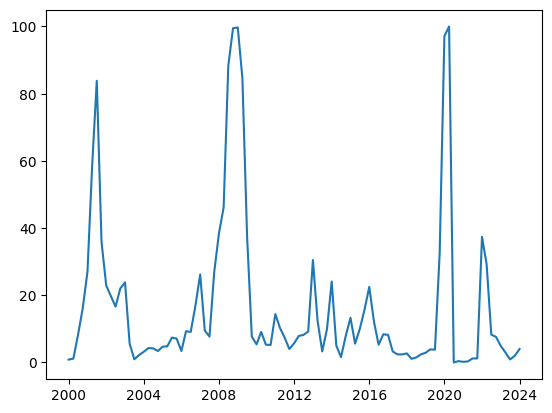

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3603618892.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["recession"].iloc[i] = 1
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3603618892.py:24: SettingWithCopyWarning: 
A valu

In [90]:
recession_indicator_index = fred.get_series(series_id='JHGDPBRINDX', observation_start = '2000-01-01', observation_end='2024-01-01')
plt.figure()
plt.plot(recession_indicator_index)
plt.show()

recession_indicator_index = recession_indicator_index.copy()
recession_indicator_index = recession_indicator_index.to_frame(name='index')
recession_indicator_index.index = pd.to_datetime(recession_indicator_index.index)
recession_indicator_index = recession_indicator_index.resample('D').ffill()

def label_recessions(df):
    df = df.copy()
    df["recession"] = 0
    
    in_recession = False
    
    for i in range(len(df)):
        value = df["index"].iloc[i]
        
        if not in_recession:
            # recession starts
            if value > 67:
                in_recession = True
                df["recession"].iloc[i] = 1
        else:
            # currently in recession
            df["recession"].iloc[i] = 1
            
            # recession ends
            if value < 33:
                in_recession = False
    
    return df

fred_rec = label_recessions(recession_indicator_index)

In [91]:
fred_rec

,index,recession
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0
2023-12-31,2.0000,0


In [92]:
fred_rec = fred_rec.reset_index()
fred_rec.columns = ['Date', 'index', 'recession']

# Make sure Date is datetime
fred_rec['Date'] = pd.to_datetime(fred_rec['Date'])
fred_rec.set_index('Date')

,index,recession
Date,,
2000-01-01,0.8612,0
2000-01-02,0.8612,0
2000-01-03,0.8612,0
2000-01-04,0.8612,0
2000-01-05,0.8612,0
...,...,...
2023-12-28,2.0000,0
2023-12-29,2.0000,0
2023-12-30,2.0000,0


In [93]:
def seperate_by_recession(results, recession):
    common_dates = results.index.intersection(recession.index)
    
    if len(common_dates) == 0:
        print("WARNING: No overlapping dates between results and recession!")
        return results.copy(), pd.DataFrame()
    
    # Filter regimes untuk tanggal yang ada di results
    recession_regimes = recession.loc[common_dates]
    
    # Separate
    non_recession_dates = recession_regimes[recession_regimes == 0].index
    recession_dates = recession_regimes[recession_regimes == 1].index
    
    non_recession_dates = results.loc[non_recession_dates].copy()
    recession_dates = results.loc[recession_dates].copy()
    
    print(f"\nFound {len(non_recession_dates)} non recession days")
    print(f"Found {len(recession_dates)} recession days")
    print(f"Total: {len(non_recession_dates) + len(recession_dates)} days")
    
    return recession_dates, non_recession_dates

In [94]:
def analyze_by_regime(recession_dates, non_recession_dates):
    """
    Analisis performance untuk masing-masing regime
    """
    print("\n" + "="*70)
    print("REGIME ANALYSIS - WALK-FORWARD RESULTS")
    print("="*70)
    
    total_days = len(non_recession_dates) + len(recession_dates)
    print(f"\nNon-Recession Days:  {len(non_recession_dates):>6} ({len(non_recession_dates)/total_days*100:>5.1f}%)")
    print(f"Recession Days: {len(recession_dates):>6} ({len(recession_dates)/total_days*100:>5.1f}%)")
    
    print("\n" + "-"*70)
    print(f"{'Metric':<35} {'Non-Recession':>15} {'Recession':>15}")
    print("-"*70)
    
    # Low Vol Stats
    if len(non_recession_dates) > 0:
        low_strat_ret = non_recession_dates['strategy_ret'].mean() * 252 * 100
        low_strat_vol = non_recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        low_strat_sharpe = non_recession_dates['strategy_ret'].mean() / non_recession_dates['strategy_ret'].std() * np.sqrt(252) if non_recession_dates['strategy_ret'].std() > 0 else 0
        low_bh_ret = non_recession_dates['ret'].mean() * 252 * 100
        low_bh_vol = non_recession_dates['ret'].std() * np.sqrt(252) * 100
        low_bh_sharpe = non_recession_dates['ret'].mean() / non_recession_dates['ret'].std() * np.sqrt(252) if non_recession_dates['ret'].std() > 0 else 0
        low_win = (non_recession_dates['strategy_ret'] > 0).sum() / len(non_recession_dates) * 100
        low_strat_total = (1 + non_recession_dates['strategy_ret']).prod() - 1
        low_bh_total = (1 + non_recession_dates['ret']).prod() - 1
    else:
        low_strat_ret = low_strat_vol = low_strat_sharpe = 0
        low_bh_ret = low_bh_vol = low_bh_sharpe = low_win = 0
        low_strat_total = low_bh_total = 0
    
    # High Vol Stats
    if len(recession_dates) > 0:
        high_strat_ret = recession_dates['strategy_ret'].mean() * 252 * 100
        high_strat_vol = recession_dates['strategy_ret'].std() * np.sqrt(252) * 100
        high_strat_sharpe = recession_dates['strategy_ret'].mean() / recession_dates['strategy_ret'].std() * np.sqrt(252) if recession_dates['strategy_ret'].std() > 0 else 0
        high_bh_ret = recession_dates['ret'].mean() * 252 * 100
        high_bh_vol = recession_dates['ret'].std() * np.sqrt(252) * 100
        high_bh_sharpe = recession_dates['ret'].mean() / recession_dates['ret'].std() * np.sqrt(252) if recession_dates['ret'].std() > 0 else 0
        high_win = (recession_dates['strategy_ret'] > 0).sum() / len(recession_dates) * 100
        high_strat_total = (1 + recession_dates['strategy_ret']).prod() - 1
        high_bh_total = (1 + recession_dates['ret']).prod() - 1
    else:
        high_strat_ret = high_strat_vol = high_strat_sharpe = 0
        high_bh_ret = high_bh_vol = high_bh_sharpe = high_win = 0
        high_strat_total = high_bh_total = 0
    
    print(f"{'Total Return (Strategy)':<35} {low_strat_total*100:>14.2f}% {high_strat_total*100:>14.2f}%")
    print(f"{'Total Return (Buy&Hold)':<35} {low_bh_total*100:>14.2f}% {high_bh_total*100:>14.2f}%")
    print(f"{'Ann. Return (Strategy)':<35} {low_strat_ret:>14.2f}% {high_strat_ret:>14.2f}%")
    print(f"{'Ann. Return (Buy&Hold)':<35} {low_bh_ret:>14.2f}% {high_bh_ret:>14.2f}%")
    print(f"{'Ann. Volatility (Strategy)':<35} {low_strat_vol:>14.2f}% {high_strat_vol:>14.2f}%")
    print(f"{'Ann. Volatility (Buy&Hold)':<35} {low_bh_vol:>14.2f}% {high_bh_vol:>14.2f}%")
    print(f"{'Sharpe Ratio (Strategy)':<35} {low_strat_sharpe:>15.2f} {high_strat_sharpe:>15.2f}")
    print(f"{'Sharpe Ratio (Buy&Hold)':<35} {low_bh_sharpe:>15.2f} {high_bh_sharpe:>15.2f}")
    print(f"{'Win Rate (Strategy)':<35} {low_win:>14.2f}% {high_win:>14.2f}%")
    
    print("="*70)

    

In [95]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

models = {}
all_results = {}

for ticker in asset_list:
    results = run_strategy_on_asset(ticker)
    all_results[ticker] = results
    market_ret = results['ret']
    # Fit on in-sample window
    model = MarkovRegression(
        market_ret,
        k_regimes=2,
        trend="c",
        switching_variance=True
    )

    models[ticker] = model.fit()
    


C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval="1d", start="2000-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\3072823659.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'].fillna(0, inplace=True)
C:\Users\Sebas\AppData\Local\

In [96]:
all_results['SPY']

Price,signal,strategy_ret,ret
Ticker,,,
Date,,,
2003-01-03,0.0,0.0,0.003075
2003-01-06,0.0,0.0,0.017624
2003-01-07,0.0,-0.0,-0.002474
2003-01-08,0.0,-0.0,-0.014450
2003-01-09,0.0,0.0,0.015537
...,...,...,...
2022-12-23,0.0,0.0,0.005752
2022-12-27,0.0,-0.0,-0.003944


In [97]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Separate and analyze
    results = all_results[ticker]
    recession_dates, non_recession_dates = seperate_by_recession(results, fred_rec)
    analyze_by_regime(recession_dates, non_recession_dates)


ASSET: SPY

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:       0 (  0.0%)
Recession Days:   5034 (100.0%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                       0.00%         398.70%
Total Return (Buy&Hold)                       0.00%         516.35%
Ann. Return (Strategy)                        0.00%           8.93%
Ann. Return (Buy&Hold)                        0.00%          10.93%
Ann. Volatility (Strategy)                    0.00%          13.28%
Ann. Volatility (Buy&Hold)                    0.00%          19.11%
Sharpe Ratio (Strategy)                        0.00            0.67
Sharpe Ratio (Buy&Hold)                        0.00            0.57
Win Rate (Strategy)                           0.00%          42.81%

ASSET: QQQ

REGIME ANALYSIS - WALK-FORWARD RESULTS

No

In [98]:
for ticker in asset_list:
    print(f"\n{'='*70}")
    print(f"ASSET: {ticker}")
    print(f"{'='*70}")
    
    # Get regime from that asset's model
    regime = models[ticker].smoothed_marginal_probabilities.idxmax(axis=1)
    
    # Separate and analyze
    results = all_results[ticker]
    low_vol, high_vol = seperate_by_regimes(results, regime)
    analyze_by_regime(low_vol, high_vol)


ASSET: SPY

Found 3671 low volatility days
Found 1363 high volatility days
Total: 5034 days

REGIME ANALYSIS - WALK-FORWARD RESULTS

Non-Recession Days:    1363 ( 27.1%)
Recession Days:   3671 ( 72.9%)

----------------------------------------------------------------------
Metric                                Non-Recession       Recession
----------------------------------------------------------------------
Total Return (Strategy)                     -70.16%        1571.49%
Total Return (Buy&Hold)                     -77.60%        2651.83%
Ann. Return (Strategy)                      -20.47%          19.85%
Ann. Return (Buy&Hold)                      -22.44%          23.33%
Ann. Volatility (Strategy)                   19.32%          10.07%
Ann. Volatility (Buy&Hold)                   32.27%          10.59%
Sharpe Ratio (Strategy)                       -1.06            1.97
Sharpe Ratio (Buy&Hold)                       -0.70            2.20
Win Rate (Strategy)                       

In [99]:
import statsmodels.api as sm

def newey_west_alpha_test(res):
    y = res['strategy_ret'] - res['ret']      # strategy excess over market
    X = np.ones(len(y))                       # constant only
    model = sm.OLS(y, X)
    nw = model.fit(cov_type='HAC', cov_kwds={'maxlags':5})
    return nw.tvalues[0], nw.pvalues[0]

for ticker in asset_list:
    results = all_results[ticker]
    t_values, p_values = newey_west_alpha_test(results)
    print(f"{ticker} t_values = {t_values}")
    print(f"{ticker} p_values = {p_values}")
    print("=" * 70)

SPY t_values = -0.7613185825820047
SPY p_values = 0.4464668039990418
QQQ t_values = -1.1102143497908803
QQQ p_values = 0.26690667064983165
DIA t_values = -1.365006746243845
DIA p_values = 0.17225092967726474
EWJ t_values = -1.0867687317642025
EWJ p_values = 0.27713902976697724
EEM t_values = -1.200608534435449
EEM p_values = 0.22990308892612654
VGK t_values = -0.7571694696329931
VGK p_values = 0.448948338606478
TLT t_values = -0.7235184919949469
TLT p_values = 0.4693613973284875
IEF t_values = -0.8058890856564
IEF p_values = 0.42030680498637074
BND t_values = -0.46967816595002065
BND p_values = 0.638584969498544
GLD t_values = -0.9847485858799185
GLD p_values = 0.3247475808769409
SLV t_values = -0.23421042727221772
SLV p_values = 0.8148216203361329
USO t_values = 0.18264488766407855
USO p_values = 0.8550766614516839
EURUSD=X t_values = 0.4542111881691908
EURUSD=X p_values = 0.649676831093924
JPY=X t_values = -0.17008151024097906
JPY=X p_values = 0.8649460343408395
AUDUSD=X t_values = -

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.

In [100]:
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(series):
    return {
        'adf_p': adfuller(series.dropna())[1],
        'kpss_p': kpss(series.dropna(), nlags='auto')[1]
    }

for ticker in asset_list:
    results = all_results[ticker]
    adf_p, kpps_p = newey_west_alpha_test(results)
    print(f"{ticker} adf p_value = {adf_p}")
    print(f"{ticker} kpps p_value = {kpps_p}")
    print("=" * 70)

SPY adf p_value = -0.7613185825820047
SPY kpps p_value = 0.4464668039990418
QQQ adf p_value = -1.1102143497908803
QQQ kpps p_value = 0.26690667064983165
DIA adf p_value = -1.365006746243845
DIA kpps p_value = 0.17225092967726474
EWJ adf p_value = -1.0867687317642025
EWJ kpps p_value = 0.27713902976697724
EEM adf p_value = -1.200608534435449
EEM kpps p_value = 0.22990308892612654
VGK adf p_value = -0.7571694696329931
VGK kpps p_value = 0.448948338606478
TLT adf p_value = -0.7235184919949469
TLT kpps p_value = 0.4693613973284875
IEF adf p_value = -0.8058890856564
IEF kpps p_value = 0.42030680498637074
BND adf p_value = -0.46967816595002065
BND kpps p_value = 0.638584969498544
GLD adf p_value = -0.9847485858799185
GLD kpps p_value = 0.3247475808769409
SLV adf p_value = -0.23421042727221772
SLV kpps p_value = 0.8148216203361329
USO adf p_value = 0.18264488766407855
USO kpps p_value = 0.8550766614516839
EURUSD=X adf p_value = 0.4542111881691908
EURUSD=X kpps p_value = 0.649676831093924
JPY=

C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.pvalues[0]
C:\Users\Sebas\AppData\Local\Temp\ipykernel_11528\2909892816.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return nw.tvalues[0], nw.

In [101]:
import numpy as np
from scipy.stats import norm

def ledoit_wolf_sharpe_test(r1, r2):
    n = len(r1)
    mean1, mean2 = np.mean(r1), np.mean(r2)
    std1, std2  = np.std(r1, ddof=1), np.std(r2, ddof=1)

    sharpe1, sharpe2 = mean1/std1, mean2/std2
    diff = sharpe1 - sharpe2

    # LW correction components
    term1 = (mean1**2 / (2 * std1**4)) * np.var((r1 - mean1)**2)
    term2 = (mean2**2 / (2 * std2**4)) * np.var((r2 - mean2)**2)
    var_diff = term1 + term2

    z = diff / np.sqrt(var_diff / n)
    p = 1 - norm.cdf(z)  # one-sided test: is Sharpe1 > Sharpe2?

    return sharpe1, sharpe2, diff, z, p

for ticker in asset_list:
    results = all_results[ticker]
    s1, s2, diff, z, p = ledoit_wolf_sharpe_test(results['strategy_ret'], results['ret'])
    print(f'p value for {ticker} = {p}')

p value for SPY = 0.0
p value for QQQ = 0.0
p value for DIA = 1.0
p value for EWJ = 1.0
p value for EEM = 1.0
p value for VGK = 1.0
p value for TLT = 1.0
p value for IEF = 1.0
p value for BND = 0.0
p value for GLD = 1.0
p value for SLV = 0.0
p value for USO = 0.0
p value for EURUSD=X = 0.0
p value for JPY=X = 0.0
p value for AUDUSD=X = 1.0
p value for BTC-USD = 0.0
p value for ETH-USD = 0.0


Regime-dependent performance, risk-adjusted excess returns, and causality once non-stationarity/autocorrelation are controlled.

In [102]:
import numpy as np

def bootstrap_significance(strategy_returns, n_boot=5000):
    actual_mean = np.mean(strategy_returns)

    boot_means = []
    for _ in range(n_boot):
        random_sign = np.random.choice([-1, 1], size=len(strategy_returns))
        boot_means.append(np.mean(strategy_returns * random_sign))

    p_value = np.mean(np.array(boot_means) >= actual_mean)
    return actual_mean, np.mean(boot_means), p_value

for ticker in asset_list:
    results = all_results[ticker]
    actual_mean, boot_mean, p_value = bootstrap_significance(results['strategy_ret'])
    print(f'{ticker} p_value = {p_value}')


SPY p_value = 0.0026
QQQ p_value = 0.0012
DIA p_value = 0.0068
EWJ p_value = 0.1306
EEM p_value = 0.3496
VGK p_value = 0.2516
TLT p_value = 0.1246
IEF p_value = 0.0192
BND p_value = 0.0228
GLD p_value = 0.1072
SLV p_value = 0.1092
USO p_value = 0.5544
EURUSD=X p_value = 0.3944
JPY=X p_value = 0.3122
AUDUSD=X p_value = 0.6774
BTC-USD p_value = 0.011
ETH-USD p_value = 0.0244


p < 0.05 → your strategy beats randomness

p > 0.05 → your “edge” disappears once randomness is modeled